<a href="https://colab.research.google.com/github/nattinun-kanp/Portfolio/blob/main/CS461_W3_Rock%2C_Paper%2C_Scissors_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# === 1. SETUP: IMPORT LIBRARIES ===
# นำเข้าเครื่องมือที่จำเป็น

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# === 2. LOAD & PREPARE DATA ===
# โหลดชุดข้อมูล Rock, Paper, Scissors จาก TensorFlow Datasets
# และแบ่งข้อมูลออกเป็นชุดสำหรับ Train และ Test

In [2]:
(ds_train_full, ds_test), ds_info = tfds.load(
    'rock_paper_scissors', split=['train', 'test'], shuffle_files=True,
    as_supervised=True, with_info=True)

# === 3. SPLIT TRAINING DATA FOR VALIDATION ===
# สร้างชุดข้อมูลสำหรับ Validation โดยแบ่งจากชุด Train เดิม (เช่น 20%)
# เพื่อให้เราสามารถวัดผลโมเดลระหว่างการเทรนได้อย่างเหมาะสม

In [3]:
# Calculate the number of samples for training and validation
num_train_samples = ds_info.splits['train'].num_examples
validation_split = 0.2 # 20% for validation
num_validation_samples = int(num_train_samples * validation_split)
num_training_samples = num_train_samples - num_validation_samples

# Split the training dataset
ds_train = ds_train_full.take(num_training_samples)
ds_validation = ds_train_full.skip(num_training_samples)

print(f"Total training samples: {num_train_samples}")
print(f"Training samples after split: {num_training_samples}")
print(f"Validation samples: {num_validation_samples}")

Total training samples: 2520
Training samples after split: 2016
Validation samples: 504


# === 4. PREPROCESS DATA ===
# สร้างฟังก์ชันเพื่อเตรียมข้อมูลรูปภาพ

In [4]:
def preprocess(image, label):
    # แปลงค่าสีของ pixel จาก 0-255 ให้เป็น 0-1 (เรียกว่า Normalization)
    # เพื่อให้โมเดลเรียนรู้ได้ง่ายขึ้น
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [5]:
# Apply the preprocess function to the datasets and batch them
BATCH_SIZE = 32

ds_train = ds_train.map(preprocess).batch(BATCH_SIZE)
ds_validation = ds_validation.map(preprocess).batch(BATCH_SIZE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE)

print("Data preprocessing and batching complete.")

Data preprocessing and batching complete.


# === 5. DEFINE THE MODEL ARCHITECTURE ===
# สร้างโครงสร้างของ Neural Network แบบเรียงต่อกัน

In [6]:
model = tf.keras.Sequential([
    # Convolutional layer to extract features from images
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    # Pooling layer to reduce spatial dimensions and computational cost
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Another convolutional and pooling layer
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten the output to feed into dense layers
    tf.keras.layers.Flatten(),

    # Dense layer with ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),

    # Output layer with softmax activation for classification
    tf.keras.layers.Dense(3, activation='softmax') # 3 classes for rock, paper, scissors
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 341056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    43,655,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,675,075 (166.61 MB)

 Trainable params: 43,675,075 (166.61 MB)

 Non-trainable params: 0 (0.00 B)

# === 6. COMPILE THE MODEL ===
# กำหนดค่าสำหรับกระบวนการเทรน

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === 7. TRAIN THE MODEL (FIT) ===
# เริ่มกระบวนการเทรนโมเดล และเก็บประวัติการเทรนไว้ในตัวแปร history

In [8]:
EPOCHS = 7 # Define the number of epochs
print("Training model...")
history = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_validation)
print("Training complete.")

Training model...
Epoch 1/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.5616 - loss: 11.7254 - val_accuracy: 0.9821 - val_loss: 0.1212
Epoch 2/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.9894 - loss: 0.0733 - val_accuracy: 0.9980 - val_loss: 0.0082
Epoch 3/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9980 - val_loss: 0.0036
Epoch 4/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 5/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 1.0000 - loss: 4.0084e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 1.0000 - loss: 2.2481e-04 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/7
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 240ms/step - accuracy: 1.0000 - loss: 1.5392e-04 - val_accuracy: 1.0000 - val_loss: 0.0012
Training complete.


# === 8. EVALUATE THE MODEL ===
# พล็อตกราฟ Training & Validation Loss เพื่อดูแนวโน้มการเรียนรู้และตรวจสอบ Overfittingประเมินประสิทธิภาพสุดท้ายของโมเดลด้วย Test set

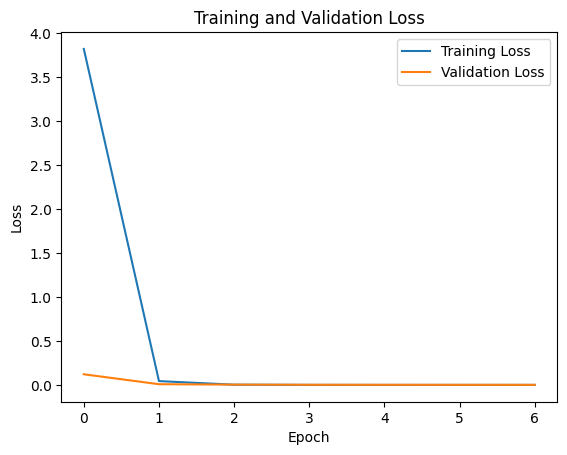

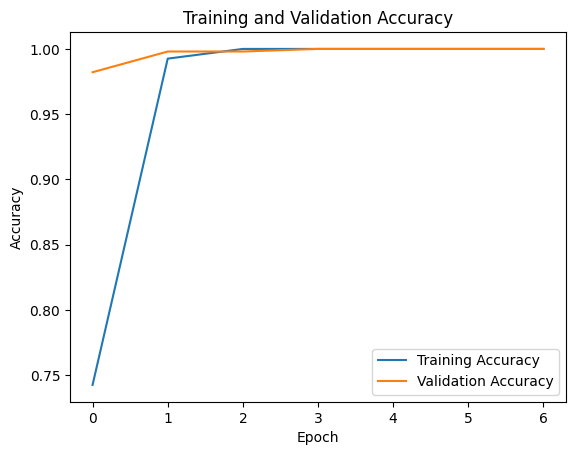

In [9]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# === 9. EVALUATE THE MODEL ON TEST DATA ===
# ประเมินประสิทธิภาพสุดท้ายของโมเดลด้วย Test set ซึ่งเป็นข้อมูลที่โมเดลไม่เคยเห็นมาก่อน

In [10]:
print("Evaluating model on test data...")
loss, accuracy = model.evaluate(ds_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print("Evaluation complete.")

Evaluating model on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.7591 - loss: 1.2606
Test Loss: 1.4766
Test Accuracy: 0.7339
Evaluation complete.
